# Modeling and Simuation Final Project v3
## DATA604 - Summer 2020
### Completed by: Philip Tanofsky
### Date: July 16, 2020

The simulation models an NBA game for a single team in addition to simulating a matchup between two teams. The matchup simulation can be extrapolated as a playoff series.

At the heart of the game model is the model of a single team possession. The possession is considered a discrete event in this model. The outcome of a single possession is zero to four points.

The model is based on overall team statistics for the NBA season 2019-20 which is currently on hiatus due to the Covid-19 pandemic. The statistics were gathered from two sources: stats.nba.com and basketball-reference.com.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import *
import numpy as np
import math
import time

## Retrieve Statistics

The team statistics for the 30 NBA teams are stored in a CSV file in the same directory as this Jupyter notebook. The file is read from the current directory and then the columns are renamed for clarity. Then, the numeric columns are type-casted to numeric data types as initially all data is read in as strings. The statistics are then output to the file for visual inspection.

In [2]:
# Read in statistics for all 30 NBA teams
filename = 'Teams_Stats_Sim_v3.csv'
all_teams = read_csv(filename, header=0, decimal='M')

# Rename the columns
all_teams.columns = ['team', 'turnover_pct_per_play', 'fga_pct_per_play', 'off_reb_per_play', 'two_pt_fg_attempts_pct', 
                  'two_pt_fg_shooting_pct', 'three_pt_fg_shooting_pct', 'ft_shooting_pct', 'shooting_foul_drawn_pct', 
                  'pace', 'off_rating', 'def_rating']


# Cast the appropriate columns to numeric instead of string
cols = ['turnover_pct_per_play', 'fga_pct_per_play', 'off_reb_per_play', 'two_pt_fg_attempts_pct', 
                  'two_pt_fg_shooting_pct', 'three_pt_fg_shooting_pct', 'ft_shooting_pct', 'shooting_foul_drawn_pct', 
                  'pace', 'off_rating', 'def_rating']   

all_teams[cols] = all_teams[cols].apply(pd.to_numeric, errors='coerce')

# Output the complete input file just for visual validation
all_teams

,team,turnover_pct_per_play,fga_pct_per_play,off_reb_per_play,two_pt_fg_attempts_pct,two_pt_fg_shooting_pct,three_pt_fg_shooting_pct,ft_shooting_pct,shooting_foul_drawn_pct,pace,off_rating,def_rating
0,ATL,0.137,0.889,0.084,0.602,0.525,0.333,0.790,0.082,103.28,107.0,114.4
1,BOS,0.119,0.886,0.093,0.618,0.519,0.363,0.801,0.079,99.78,112.3,106.2
2,BKN,0.132,0.884,0.092,0.580,0.519,0.340,0.744,0.077,101.51,107.8,108.3
3,CHA,0.132,0.892,0.099,0.601,0.489,0.352,0.748,0.091,96.24,105.9,112.8
4,CHI,0.135,0.897,0.092,0.604,0.511,0.348,0.755,0.079,100.46,105.8,108.9
5,CLE,0.144,0.898,0.095,0.638,0.519,0.351,0.758,0.085,99.17,106.9,114.8
6,DAL,0.112,0.886,0.093,0.539,0.542,0.369,0.773,0.081,99.78,115.8,110.0
7,DEN,0.121,0.896,0.095,0.658,0.529,0.358,0.775,0.086,97.66,112.0,108.9
8,DET,0.136,0.887,0.087,0.619,0.515,0.367,0.743,0.079,97.86,108.8,112.3
9,GST,0.130,0.882,0.087,0.645,0.495,0.334,0.803,0.072,101.04,104.4,113.0


## Approach

- The model is constructed using many concise functions to replicate elements of the possession.

- The season statistics for each team retrieved from the CSV file are defined as a system object.

- The game statistics for each team are defined and maintained as a state object.

### Statistics used

- Turnover percentage per play

- Field Goal Attempt percentage per play

- Offensive Rebound percentage per play

- Two-point Field Goal Attempt percentage per play

- Two-point Field Goal Shooting percentage

- Three-point Field Goal Shooting percentage

- Free-Throw Shooting percentage

- Shooting Foul Drawn percentage per play

- Overal Team Pace (possessions per game)

- Overall Team Offensive Rating

- Overall Team Defensive Rating

Following function maps in the input data (season statistics) from the primary dataframe to a system object for one team based on the input parameter.

In [3]:
def map_team_stats_to_system(team):
    """
    Given the team 3-character identifier, create a system object based on the input file of team statistics
    """
    team_stats = all_teams[all_teams['team']== team]
    
    team_sys = System(turnover_pct_per_play=team_stats.iloc[0]['turnover_pct_per_play'],
                fga_pct_per_play           =team_stats.iloc[0]['fga_pct_per_play'],
                off_reb_per_play           =team_stats.iloc[0]['off_reb_per_play'],
                two_pt_fg_attempts_pct     =team_stats.iloc[0]['two_pt_fg_attempts_pct'],
                two_pt_fg_shooting_pct     =team_stats.iloc[0]['two_pt_fg_shooting_pct'],
                three_pt_fg_shooting_pct   =team_stats.iloc[0]['three_pt_fg_shooting_pct'],
                ft_shooting_pct            =team_stats.iloc[0]['ft_shooting_pct'],
                shooting_foul_drawn_pct    =team_stats.iloc[0]['shooting_foul_drawn_pct'],
                pace                       =team_stats.iloc[0]['pace'],
                off_rating                 =team_stats.iloc[0]['off_rating'],
                def_rating                 =team_stats.iloc[0]['def_rating'])
    
    return team_sys

In [4]:
# Test map_team_stats_to_system
atl = map_team_stats_to_system('ATL')

,values
turnover_pct_per_play,0.137
fga_pct_per_play,0.889
off_reb_per_play,0.084
two_pt_fg_attempts_pct,0.602
two_pt_fg_shooting_pct,0.525
three_pt_fg_shooting_pct,0.333
ft_shooting_pct,0.790
shooting_foul_drawn_pct,0.082
pace,103.280
off_rating,107.000


Function used to create and initialize the game statistics State object for a game simulation

In [5]:
def initialize_game_stats_state():
    """
    Initialize the game statistics to zero and return State object
    """
    game_stats_state = State(turnovers=0,
                             two_point_field_goal_attempts=0,
                             two_point_field_goal_makes=0,
                             three_point_field_goal_attempts=0,
                             three_point_field_goal_makes=0,
                             free_throw_attempts=0,
                             free_throw_makes=0,
                             shooting_fouls_drawn=0,
                             offensive_rebounds=0)
    
    return game_stats_state

In [6]:
# initialize_game_stats_state
stats_state = initialize_game_stats_state()

,values
turnovers,0
two_point_field_goal_attempts,0
two_point_field_goal_makes,0
three_point_field_goal_attempts,0
three_point_field_goal_makes,0
free_throw_attempts,0
free_throw_makes,0
shooting_fouls_drawn,0
offensive_rebounds,0


Function to build the System object and State object for a team as input to a game simulation.

Display of the composite object shows the two attributes are the game statistics state and overall statistics system.

In [7]:
def create_team_game_object(team_name):
    """
    Create a team object as a composite of the game stats State object and the season statistics System object
    """
    team = State(game_stats_state=initialize_game_stats_state(),
                 overall_stats_sys=map_team_stats_to_system(team_name))
    
    return team

In [8]:
# Test create_team_game_object
spurs = create_team_game_object('SAS')

spurs

,values
game_stats_state,turnovers 0 two_point...
overall_stats_sys,turnover_pct_per_play 0.109 fga_pct_pe...


In [9]:
# Create a system object to represent a team
# team_A object used throughout the Jupyter notebook to individually test functions
team_A = map_team_stats_to_system('MIL')

,values
turnover_pct_per_play,0.127
fga_pct_per_play,0.889
off_reb_per_play,0.081
two_pt_fg_attempts_pct,0.577
two_pt_fg_shooting_pct,0.567
three_pt_fg_shooting_pct,0.356
ft_shooting_pct,0.742
shooting_foul_drawn_pct,0.084
pace,105.360
off_rating,112.300


Utility function to convert a percentage between 0.0 and 1.0 to an integer from zero to one thousand.

In [10]:
def convert_pct_to_int(pct):
    """
    Utility function to convert any percentage to an integer of range 0-1000
    """
    return int(pct * 1000)

In [11]:
# Test convert_pct_to_int function
convert_pct_to_int(.47)

470

Following function determines if a turnover occurs based on the team percentage

In [12]:
def did_turnover_occur(team):
    """
    Determine if a possession results in a turnover
    """
    
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.turnover_pct_per_play)
    
    if (rand_num <= pct):
        result = True
    
    return result

In [13]:
# Test did_turnover_occur
did_turnover_occur(team_A)

False

Following function determines if a field goal attempt occurs based on the team percentage

In [14]:
def did_field_goal_attempt_occur(team):
    """
    Determine if a possession results in a field goal attempt
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.fga_pct_per_play)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [15]:
# Test did_field_goal_attempt_occur
did_field_goal_attempt_occur(team_A)

True

Following function determines if an offensive rebound occurs based on the team percentage

In [16]:
def did_offensive_rebound_occur(team):
    """
    Determine if a play results in a offensive rebound
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.off_reb_per_play)
    
    # Setting offensive rebounding percentage to 20%
    pct = 200
    
    if (rand_num <= pct):
        result = True
        
    return result

In [17]:
# Test did_offensive_rebound_occur
did_offensive_rebound_occur(team_A)

False

Following function determines if a two-point FG attempt occurs as opposed to a three-point FG attempt based on the team percentage

In [18]:
def is_2P_FGA(team):
    """
    Determine if a two point field goal attempt occurs
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.two_pt_fg_attempts_pct)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [19]:
# Test is_2P_FGA
is_2P_FGA(team_A)

True

Following function determines if a two-point FG was successful based on the team percentage

In [20]:
def is_2P_FGA_made(team):
    """
    Determine if a two-point field goal attempt was successful
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.two_pt_fg_shooting_pct)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [21]:
# Test is_2P_FGA_made
is_2P_FGA_made(team_A)

False

Following function determines if a three-point FG was successful based on the team percentage

In [22]:
def is_3P_FGA_made(team):
    """
    Determine if a three-point field goal attempt was successful
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.three_pt_fg_shooting_pct)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [23]:
# Test is_3P_FGA_made
is_3P_FGA_made(team_A)

False

Following function determines if a free-throw attempt was successful based on the team percentage

In [24]:
def is_FTA_made(team):
    """
    Determine if a free-throw attempt was successful
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.ft_shooting_pct)
    
    if (rand_num <= pct):
        result = True
        
    return result

In [25]:
# Test is_FTA_made
is_FTA_made(team_A)

True

Following function determines if a shooting fould occurs based on the team percentage

- Note: The percentage is static for all team's at a very low percentage.

In [26]:
def did_shooting_foul_occur(team):
    """
    Determine if a shooting foul occurred
    """
    result = False
    
    # Retrieve random number
    rand_num = np.random.uniform(1, 1000)
    
    # Convert percent to int
    pct = convert_pct_to_int(team.shooting_foul_drawn_pct)
    
    
    # Hardcoding 50 for test purposes
    pct = 50
    if (rand_num <= pct):
        result = True
        
    return result

In [27]:
# Test did_shooting_foul_occur
did_shooting_foul_occur(team_A)

False

Following function simulates a free-throw attempt based on the team percentage

In [28]:
def simulate_FT_attempt(team):
    """
    Simulate a free throw attempt based on the team's free-throw percentage
    """
    # result represents the points scored
    result_pts = 0
    
    if (is_FTA_made(team)):
        result_pts += 1

    return result_pts

In [29]:
# Test simulate_FT_attempt
simulate_FT_attempt(team_A)

1

Following function simulates multiple free-throw attempts based on the input parameter 'attempts'

In [30]:
def simulate_FT_attempts(team, attempts):
    """
    Simulate free throw attempts
    """
    # result represents the points scored
    result_pts = 0
    
    # Loop through the number of attempts
    for a in range(1, attempts+1):
        result_pts += simulate_FT_attempt(team)
        
    return result_pts

In [31]:
# Test simulate_FT_attempts
simulate_FT_attempts(team_A, 2)

2

In order to determine if a team grabs an offensive rebound, the model must know if the final free throw attempt was a made basket or a miss. The below function will return the number of points scored for the given count of attempts along with a flag indicating the state of the final attempt.

In [32]:
def simulate_FT_attempts_with_final_FT_result(team, attempts):
    """
    Simulate free throw attempts
    """
    # result represents the points scored
    result_pts = 0
    result_final_FT_miss = False
    
    # Loop through the number of attempts
    for a in range(1, attempts+1):
        result = simulate_FT_attempt(team)
        result_pts += result
        # For final shot, set final FT miss flag
        if (a == attempts):
            if (result == 0):
                result_final_FT_miss = True
        
    return result_pts, result_final_FT_miss

In [33]:
# Test simulate_FT_attempts_with_final_FT_result
simulate_FT_attempts_with_final_FT_result(team_A, 2)

(2, False)

To accurately reflect a true basketball possession, the model takes into account the possibility of the "and-one" shooting foul on a made field goal.

In [34]:
def simulate_2P_FG_attempt_with_shooting_foul_possible(team):
    """
    Simulate a two-point field goal attempt
    """
    # result represents the points scored
    result_pts = 0
    result_miss_fg = False
    result_miss_ft = False

    result_2P_FGA = is_2P_FGA_made(team)
    
    if (result_2P_FGA):
        # FG attempt was made, add two points
        result_pts += 2
        
        is_shooting_foul_drawn = did_shooting_foul_occur(team)
                    
        if (is_shooting_foul_drawn):            
            # simulate free throw attempt
            pts, is_final_FT_missed = simulate_FT_attempts_with_final_FT_result(team_A, 1)
            result_pts += pts
            result_miss_ft = is_final_FT_missed
    else:
        result_pts = 0
        result_miss_fg = True
        
    return result_pts, result_miss_fg, result_miss_ft

In [35]:
# Test simulate_2P_FG_attempt_with_shooting_foul_possible
simulate_2P_FG_attempt_with_shooting_foul_possible(team_A)

(2, False, False)

Following function simulates a two-point FG attempt

In [36]:
def simulate_2P_FG_attempt(team):
    """
    Simulate a two-point field goal attempt
    """
    # result represents the points scored
    result_pts = 0
    
    if (is_2P_FGA_made(team)):
        result_pts += 2
        
    return result_pts

In [37]:
# Test simulate_2P_FG_attempt
simulate_2P_FG_attempt(team_A)

2

Following function simulates a three-point FG attempt

In [38]:
def simulate_3P_FG_attempt(team):
    """
    Simulate a three-point field goal attempt
    """
    # result represents the points scored
    result_pts = 0
    
    if (is_3P_FGA_made(team)):
        result_pts += 3
        
    return result_pts

In [39]:
# Test simulate_3P_FG_attempt
simulate_3P_FG_attempt(team_A)

3

Again, to accurately reflect a true basketball possession, the model takes into account the possibility of the "and-one" shooting foul on a made field goal.

In [40]:
def simulate_3P_FG_attempt_with_shooting_foul_possible(team):
    """
    Simulate a three-point field goal attempt
    """
    # result represents the points scored
    result_pts = 0
    result_miss_fg = False
    result_miss_ft = False

    result_3P_FGA = is_3P_FGA_made(team)
    
    if (result_3P_FGA):
        # FG attempt was made, add three points
        result_pts += 3
        
        is_shooting_foul_drawn = did_shooting_foul_occur(team)
                    
        if (is_shooting_foul_drawn):            
            # simulate free throw attempt
            pts, is_final_FT_missed = simulate_FT_attempts_with_final_FT_result(team_A, 1)
            result_pts += pts
            result_miss_ft = is_final_FT_missed
    else:
        result_pts = 0
        result_miss_fg = True
        
    return result_pts, result_miss_fg, result_miss_ft

In [41]:
# Test simulate_3P_FG_attempt_with_shooting_foul_possible
simulate_3P_FG_attempt_with_shooting_foul_possible(team_A)

(0, True, False)

This function will modify a team's field-goal percentage based on the difference between the team's offensive rating and the opponent's defensive rating. Please note, a better defensive rating is a lower rating. The linear formula used to determine the amount to change is based on all the games of the 2019-20 NBA season to date.

A good defensive team will cause a decrease in the field-goal shooting percentage.

This function, along with the following two, are used to better simulate the matchup between two teams. Simply running the simulation for two teams independent of impact on one another ends up rewarding strong offensive teams. By creating this functions to account for opponent's defensive rating, the percentages of a team are adjusted according to the specific opponent.

In [42]:
def calculate_fg_pct_based_on_opp(team_off_rating, opp_def_rating, team_fg_pct):
    """
    Calculate a shooting percentage based on the overall team offensive rating and opponent's defensive rating
    """
    # 0.00355*x + -0.00505
    # Based on linear regression formula
    return (0.00355 * (opp_def_rating - team_off_rating) - 0.00505) + team_fg_pct

In [43]:
calculate_fg_pct_based_on_opp(111.3, 101.6, 0.47)

0.430515

This function will modify a team's three-point field-goal percentage based on the difference between the team's offensive rating and the opponent's defensive rating. Please note, a better defensive rating is a lower rating. The linear formula used to determine the amount to change is based on all the games of the 2019-20 NBA season to date.

A good defensive team will cause a decrease in the three-point field-goal shooting percentage.

In [44]:
def calculate_3p_fg_pct_based_on_opp(team_off_rating, opp_def_rating, team_3p_fg_pct):
    """
    Calculate a shooting percentage based on the overall team offensive rating and opponent's defensive rating
    """
    # 0.00463*x + -0.00847
    # Based on linear regression formula
    return (0.00463 * (opp_def_rating - team_off_rating) - 0.00847) + team_3p_fg_pct

In [45]:
calculate_3p_fg_pct_based_on_opp(111.3, 101.6, 0.383)

0.329619

This function will modify a team's turnover percentage based on the difference between the team's offensive rating and the opponent's defensive rating. Please note, a better defensive rating is a lower rating. The linear formula used to determine the amount to change is based on all the games of the 2019-20 NBA season to date.

A good defensive team will cause an increase in the turnover percentage.

In [46]:
def calculate_turnover_pct_based_on_opp(team_off_rating, opp_def_rating, turnover_pct):
    """
    Calculate a turnover percentage based on the overall team offensive rating and opponent's defensive rating
    """
    # -0.000993*x + -0.00478
    # Based on linear regression formula
    return (-0.000993 * (opp_def_rating - team_off_rating) - 0.00478) + turnover_pct

In [47]:
calculate_turnover_pct_based_on_opp(111.3, 101.6, 0.136)

0.1408521

In [48]:
calculate_turnover_pct_based_on_opp(112.3, 114.6, 0.136)

0.1289361

Utility function used to keep a running total of the game statistics from each possession simulation.

In [49]:
def combine_poss_stats(poss_stats_running, poss_stats_instance):
    
    poss_stats_running.turnovers                       += poss_stats_instance.turnovers
    poss_stats_running.two_point_field_goal_attempts   += poss_stats_instance.two_point_field_goal_attempts
    poss_stats_running.two_point_field_goal_makes      += poss_stats_instance.two_point_field_goal_makes
    poss_stats_running.three_point_field_goal_attempts += poss_stats_instance.three_point_field_goal_attempts
    poss_stats_running.three_point_field_goal_makes    += poss_stats_instance.three_point_field_goal_makes
    poss_stats_running.free_throw_attempts             += poss_stats_instance.free_throw_attempts
    poss_stats_running.free_throw_makes                += poss_stats_instance.free_throw_makes
    poss_stats_running.shooting_fouls_drawn            += poss_stats_instance.shooting_fouls_drawn
    poss_stats_running.offensive_rebounds              += poss_stats_instance.offensive_rebounds
    
    return poss_stats_running

In [50]:
# Test combine_poss_stats

running = State(turnovers=1,
                two_point_field_goal_attempts=3,
                two_point_field_goal_makes=4,
                three_point_field_goal_attempts=2,
                three_point_field_goal_makes=7,
                free_throw_attempts=10,
                free_throw_makes=8,
                shooting_fouls_drawn=2,
                offensive_rebounds=5)

instanc = State(turnovers=6,
                two_point_field_goal_attempts=5,
                two_point_field_goal_makes=2,
                three_point_field_goal_attempts=2,
                three_point_field_goal_makes=8,
                free_throw_attempts=4,
                free_throw_makes=9,
                shooting_fouls_drawn=2,
                offensive_rebounds=1)

running = combine_poss_stats(running, instanc)

running

,values
turnovers,7
two_point_field_goal_attempts,8
two_point_field_goal_makes,6
three_point_field_goal_attempts,4
three_point_field_goal_makes,15
free_throw_attempts,14
free_throw_makes,17
shooting_fouls_drawn,4
offensive_rebounds,6


This function, simulate_possession, is the heart of the NBA game model. This is the primary function in which a possession is simulated with the result being the number of points scored in the possession along with the game statistics of the possession itself.

In [51]:
def simulate_possession(team):
    """
    Simulate a possession for the given team
    """
    
    # Track stats for possession
    poss_stats = initialize_game_stats_state()
    
    result_pts = 0
    
    is_turnover = did_turnover_occur(team)
    
    if (is_turnover):
        # Turnover occured, return 0 points
        # Line not necessary, but leaving in for clarity
        poss_stats.turnovers += 1
        result_pts = 0
    else:
        # Check if FGA occurred vs. FT attempts
        is_FGA = did_field_goal_attempt_occur(team)
        
        if (is_FGA):
            # FG attempted: 2P or 3P
            result_2P_FGA = is_2P_FGA(team)
            
            if (result_2P_FGA):
                # 2P Field Goal attempted
                pts, miss_fg, miss_ft = simulate_2P_FG_attempt_with_shooting_foul_possible(team)
                result_pts += pts
                
                # Count shot attempt
                poss_stats.two_point_field_goal_attempts += 1
                
                if (pts == 2):
                    poss_stats.two_point_field_goal_makes += 1
                    if (miss_ft):
                        poss_stats.free_throw_attempts += 1
                        poss_stats.shooting_fouls_drawn += 1
                elif (pts == 3):
                    poss_stats.two_point_field_goal_makes += 1
                    poss_stats.free_throw_attempts += 1
                    poss_stats.free_throw_makes += 1
                    poss_stats.shooting_fouls_drawn += 1
                
                # Opportunity for offensive rebound
                if (miss_fg or miss_ft):
                
                    offensive_rebound = did_offensive_rebound_occur(team)
                    
                    if (offensive_rebound):
                        # Possession starts over
                        poss_stats.offensive_rebounds += 1
                        # Recursively call simulate_possession
                        poss_pts_recur, poss_stats_recur = simulate_possession(team)
                        result_pts += poss_pts_recur
                        poss_stats = combine_poss_stats(poss_stats, poss_stats_recur)
                    # else: Offensive rebound did not occur; Possession over
                # else: Nothing here, as opposing team will inbound ball; Possession over
            else:
                # 3P Field Goal attempted
                pts, miss_fg, miss_ft = simulate_3P_FG_attempt_with_shooting_foul_possible(team)
                result_pts += pts
                
                # Count shot attempt
                poss_stats.three_point_field_goal_attempts += 1
                
                if (pts == 3):
                    poss_stats.three_point_field_goal_makes += 1
                    if (miss_ft):
                        poss_stats.free_throw_attempts += 1
                        poss_stats.shooting_fouls_drawn += 1
                elif (pts == 4):
                    poss_stats.three_point_field_goal_makes += 1
                    poss_stats.free_throw_attempts += 1
                    poss_stats.free_throw_makes += 1
                    poss_stats.shooting_fouls_drawn += 1
                
                # Opportunity for offensive rebound
                if (miss_fg or miss_ft):
                
                    offensive_rebound = did_offensive_rebound_occur(team)
                    
                    if (offensive_rebound):
                        # Possession starts over
                        poss_stats.offensive_rebounds += 1
                        # Recursively call simulate_possession
                        poss_pts_recur, poss_stats_recur = simulate_possession(team)
                        result_pts += poss_pts_recur
                        poss_stats = combine_poss_stats(poss_stats, poss_stats_recur)
                    # else: Offensive rebound did not occur; Possession over
                # else: Nothing here, as opposing team will inbound ball; Possession over
                    
        else:
            # Free throw attempts
            pts, miss = simulate_FT_attempts_with_final_FT_result(team_A, 2)
            result_pts += pts
            
            poss_stats.free_throw_attempts += 2
            poss_stats.shooting_fouls_drawn += 1
            
            if (pts == 1):
                poss_stats.free_throw_makes += 1
            elif (pts == 2):
                poss_stats.free_throw_makes += 2
            
            # Opportunity for offensive rebound
            if (miss):
                
                offensive_rebound = did_offensive_rebound_occur(team)
                    
                if (offensive_rebound):
                    # Possession starts over
                    poss_stats.offensive_rebounds += 1
                    # Recursively call simulate_possession
                    poss_pts_recur, poss_stats_recur = simulate_possession(team)
                    result_pts += poss_pts_recur
                    poss_stats = combine_poss_stats(poss_stats, poss_stats_recur)
                # else: Offensive rebound did not occur; Possession over
            # else: Nothing here, as opposing team will inbound ball; Possession over
            
    return result_pts, poss_stats

In [52]:
# Test simulate_possession
simulate_possession(team_A)

(3,
 turnovers                          0
 two_point_field_goal_attempts      0
 two_point_field_goal_makes         0
 three_point_field_goal_attempts    1
 three_point_field_goal_makes       1
 free_throw_attempts                0
 free_throw_makes                   0
 shooting_fouls_drawn               0
 offensive_rebounds                 0
 dtype: int64)

simulate_game function simply calls the simulate_possession function a total number of times based on the team's pace of play.

In [53]:
def simulate_game(team):
    """
    Simulate a game by summing results of all possessions
    """
    score = 0
    score_at_poss = TimeSeries()
    # Track stats for game
    game_stats = initialize_game_stats_state()
    
    score_at_poss[0] = score
    for p in range(1, math.ceil(team.pace)+1):
        poss_pts, poss_stats = simulate_possession(team)
        score += poss_pts
        score_at_poss[p] = score
        
        game_stats = combine_poss_stats(game_stats, poss_stats)
        
    return score_at_poss, game_stats

simuate_game function is verified along with a plot to illustrate the team's score increasing along with the possessions.

126

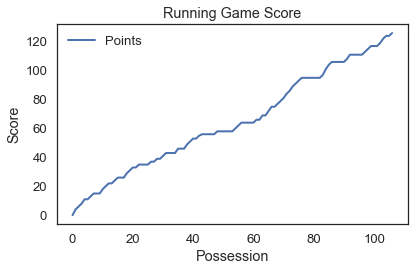

In [54]:
# Test simulate_game
game_score, game_stats = simulate_game(team_A)

plot(game_score, label='Points')

decorate(title='Running Game Score',
         xlabel='Possession', 
         ylabel='Score')

game_score.max()

As a means of validation, confirming the model fits the real-world system expectations, the final game statistics State object is output to screen to allow for comparison with the team's real per game totals.

In [55]:
game_stats

,values
turnovers,5
two_point_field_goal_attempts,49
two_point_field_goal_makes,28
three_point_field_goal_attempts,49
three_point_field_goal_makes,15
free_throw_attempts,29
free_throw_makes,25
shooting_fouls_drawn,15
offensive_rebounds,11


Avg Score  : 118.2
Avg TOs    : 11.5
Avg 2P FGAs: 60.3
Avg 2P FGMs: 33.0
Avg 3P FGAs: 27.5
Avg 3P FGMs: 10.5
Avg FTAs   : 27.5
Avg FTMs   : 20.7
Avg SFs    : 15.1
Avg OffRebs: 10.7


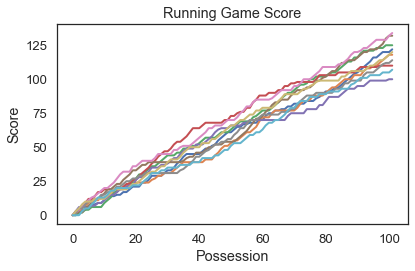

In [56]:
# Let's find the average score for a team (Spurs) ... should be about 113
# Validation of the simulate_game model
spurs = map_team_stats_to_system('SAS')


results = TimeSeries()
turnovers = TimeSeries()
two_point_field_goal_attempts = TimeSeries()
two_point_field_goal_makes = TimeSeries()
three_point_field_goal_attempts = TimeSeries()
three_point_field_goal_makes = TimeSeries()
free_throw_attempts = TimeSeries()
free_throw_makes = TimeSeries()
shooting_fouls_drawn = TimeSeries()
offensive_rebounds = TimeSeries()

for g in range(1, 11):    
    game_score, game_stats = simulate_game(spurs)
    results[g] = game_score.max()
    turnovers[g] = game_stats.turnovers
    two_point_field_goal_attempts[g] = game_stats.two_point_field_goal_attempts
    two_point_field_goal_makes[g] = game_stats.two_point_field_goal_makes
    three_point_field_goal_attempts[g] = game_stats.three_point_field_goal_attempts
    three_point_field_goal_makes[g] = game_stats.three_point_field_goal_makes
    free_throw_attempts[g] = game_stats.free_throw_attempts
    free_throw_makes[g] = game_stats.free_throw_makes
    shooting_fouls_drawn[g] = game_stats.shooting_fouls_drawn
    offensive_rebounds[g] = game_stats.offensive_rebounds
    plot(game_score)

decorate(title='Running Game Score',
         xlabel='Possession', 
         ylabel='Score')
    
    
print("Avg Score  :", results.mean())
print("Avg TOs    :", turnovers.mean())
print("Avg 2P FGAs:", two_point_field_goal_attempts.mean())
print("Avg 2P FGMs:", two_point_field_goal_makes.mean())
print("Avg 3P FGAs:", three_point_field_goal_attempts.mean())
print("Avg 3P FGMs:", three_point_field_goal_makes.mean())
print("Avg FTAs   :", free_throw_attempts.mean())
print("Avg FTMs   :", free_throw_makes.mean())
print("Avg SFs    :", shooting_fouls_drawn.mean())
print("Avg OffRebs:", offensive_rebounds.mean())

For documentation purposes: I ran the above simulation 100 times for the Spurs at 11:28am CT 7/12/20. Here are the results:

- Avg Score  : 113.26

- Avg TOs    : 11.33

- Avg 2P FGAs: 59.18

- Avg 2P FGMs: 31.03

- Avg 3P FGAs: 29.18

- Avg 3P FGMs: 11.2

- Avg FTAs   : 23.74

- Avg FTMs   : 17.6

- Avg SFs    : 12.91

- Avg OffRebs: 9.52

Spurs 2019-20 season per-game averages according to https://stats.nba.com/teams/traditional/

- Points     : 113.2

- Turnovers  : 12.3

- 2P FGAs    : 60.8 (89.5 - 28.7)

- 2P FGMs    : 31.3 (42.0 - 10.7)

- 3P FGAs    : 28.7

- 3P FGMs    : 10.7

- FTAs       : 22.8

- FTMs       : 18.4

- SFs        : --

- OffRebs    : 8.8

Below plot shows the distribution of final game score for each of the simulations run.

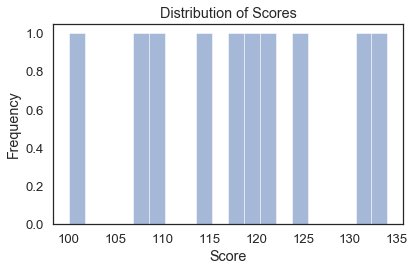

In [57]:
game_totals_ser = pandas.Series(results)

game_totals_ser.plot.hist(bins=20, alpha=0.5, legend=False)

decorate(title='Distribution of Scores',
         xlabel='Score', 
         ylabel='Frequency',
         legend=None)

In order to ensure the same pace for two teams, the average of the two teams' paces are calculated.

In [58]:
def calculate_pace_of_game(team_one_pace, team_two_pace):
    """
    Calculate pace of a game between two teams
    """
    # Calculate average of the pace given the two teams
    return (team_one_pace + team_two_pace) / 2

In [59]:
pace = calculate_pace_of_game(100.6, 101.3)

100.94999999999999

The below function, simulate_matchup_between_two_teams, is the heart of the model that simulates a game between two teams.

In [60]:
def simulate_matchup_between_two_teams(team_1, team_2, games):
    """
    Simulate a matchup between two teams.
    High level: The simulate_game function is called for each team, and then the results (final scores) are compared
    Algorithm does identify tie games and runs a simulation for overtime until there is a winner
    games: games per matchup simulation
    """
    
    m_start_time = time.time()
    
    # Map statistics from input file
    team_one = map_team_stats_to_system(team_1)
    team_two = map_team_stats_to_system(team_2)
    
    # Calculate pace of game based on the two teams
    matchup_pace =  calculate_pace_of_game(team_one.pace, team_two.pace)
    
    # Modify shooting percentages based on offensive and defensive team ratings
    team_one.two_pt_fg_shooting_pct = calculate_fg_pct_based_on_opp(team_one.off_rating, team_two.def_rating, team_one.two_pt_fg_shooting_pct)
    team_one.three_pt_fg_shooting_pct = calculate_3p_fg_pct_based_on_opp(team_one.off_rating, team_two.def_rating, team_one.three_pt_fg_shooting_pct)
    
    team_two.two_pt_fg_shooting_pct = calculate_fg_pct_based_on_opp(team_two.off_rating, team_one.def_rating, team_two.two_pt_fg_shooting_pct)
    team_two.three_pt_fg_shooting_pct = calculate_3p_fg_pct_based_on_opp(team_two.off_rating, team_one.def_rating, team_two.three_pt_fg_shooting_pct)

    # Modify turnover percentages based on offensive and defensive team ratings
    team_one.turnover_pct_per_play = calculate_turnover_pct_based_on_opp(team_one.off_rating, team_two.def_rating, team_one.turnover_pct_per_play)
    team_two.turnover_pct_per_play = calculate_turnover_pct_based_on_opp(team_two.off_rating, team_one.def_rating, team_two.turnover_pct_per_play)

    
    # Initialize matchup state
    matchup = State(team_one_wins=0,
                    team_two_wins=0,
                    overtime_games=0,
                    games=0,
                    team_one_score=TimeSeries(),
                    team_two_score=TimeSeries(),
                    team_one=team_1,
                    team_two=team_2)
    
    # Create TimeSeries object to track the game result difference
    game_result_diff = TimeSeries()
    
    # Loop through a game X number of times based on input parameter
    for g in range(1, games+1):
        matchup.games += 1
                
        # Always re-initialize pace
        team_one.pace = matchup_pace
        team_two.pace = matchup_pace
        
        gm_team_one, gm_team_one_stats = simulate_game(team_one)
        gm_team_two, gm_team_two_stats = simulate_game(team_two)
        
        if (gm_team_one.max() > gm_team_two.max()):
            matchup.team_one_wins += 1
            matchup.team_one_score[g] = gm_team_one.max()
            matchup.team_two_score[g] = gm_team_two.max()
            game_result_diff[g] = gm_team_one.max() - gm_team_two.max()
        elif (gm_team_two.max() > gm_team_one.max()):
            matchup.team_two_wins += 1
            matchup.team_one_score[g] = gm_team_one.max()
            matchup.team_two_score[g] = gm_team_two.max()
            game_result_diff[g] = gm_team_one.max() - gm_team_two.max()
        else:
            # Tie: Send game to overtime
            matchup.overtime_games += 1
            score_tied = True
            
            # Modify pace for 5 minutes
            ot_pace = (matchup_pace / 48) * 5
            team_one.pace = ot_pace
            team_two.pace = ot_pace
            
            while (score_tied):
                
                gm_team_one, gm_team_one_stats = (simulate_game(team_one))
                gm_team_two, gm_team_two_stats = (simulate_game(team_two))
                
                if (gm_team_one.max() > gm_team_two.max()):
                    matchup.team_one_wins += 1
                    matchup.team_one_score[g] = gm_team_one.max()
                    matchup.team_two_score[g] = gm_team_two.max()
                    game_result_diff[g] = gm_team_one.max() - gm_team_two.max()
                    score_tied = False
                elif (gm_team_two.max() > gm_team_one.max()):
                    matchup.team_two_wins += 1
                    matchup.team_one_score[g] = gm_team_one.max()
                    matchup.team_two_score[g] = gm_team_two.max()
                    game_result_diff[g] = gm_team_one.max() - gm_team_two.max()
                    score_tied = False
 
    print("Matchup run time: %s seconds ---" % (time.time() - m_start_time))
        
    return matchup, game_result_diff

In [61]:
# Test map_team_stats_to_system
team_A = map_team_stats_to_system('DAL')

team_A

,values
turnover_pct_per_play,0.112
fga_pct_per_play,0.886
off_reb_per_play,0.093
two_pt_fg_attempts_pct,0.539
two_pt_fg_shooting_pct,0.542
three_pt_fg_shooting_pct,0.369
ft_shooting_pct,0.773
shooting_foul_drawn_pct,0.081
pace,99.780
off_rating,115.800


In [62]:
# Test simulate_matchup_between_two_teams
matchup_results, pt_diffs = simulate_matchup_between_two_teams('MIL', 'LAL', 5)

print(matchup_results.team_one, "wins:", matchup_results.team_one_wins)
print(matchup_results.team_two, "wins:", matchup_results.team_two_wins)
print("Overtime games:", matchup_results.overtime_games)
print("Total Games:", matchup_results.games)

Matchup run time: 3.4540181159973145 seconds ---
MIL wins: 3
LAL wins: 2
Overtime games: 0
Total Games: 5


A plot of the score difference for each game of the two-team matchup simulation.

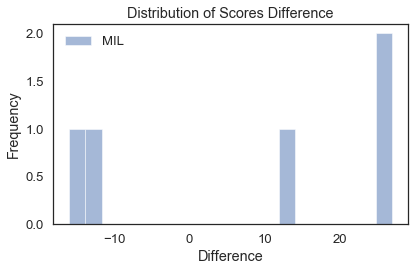

In [63]:
pt_diffs_ser = pandas.Series(pt_diffs)

pt_diffs_ser.plot.hist(bins=20, alpha=0.5, label='MIL')

decorate(title='Distribution of Scores Difference',
         xlabel='Difference', 
         ylabel='Frequency',
         legend='MIL')

In [64]:
pt_diffs.mean()

7.6

Plot of the point distribution for both teams identified above.

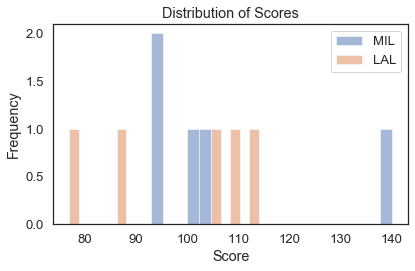

In [65]:
from matplotlib import pyplot

team_one_scores = pandas.Series(matchup_results.team_one_score)
team_two_scores = pandas.Series(matchup_results.team_two_score)

pyplot.hist(team_one_scores, bins=20, alpha=0.5, label=matchup_results.team_one)
pyplot.hist(team_two_scores, bins=20, alpha=0.5, label=matchup_results.team_two)
pyplot.legend(loc='upper right')
decorate(title='Distribution of Scores',
         xlabel='Score', 
         ylabel='Frequency',
         legend=None)
pyplot.show()

Plot of the point totals for both teams for all simulations

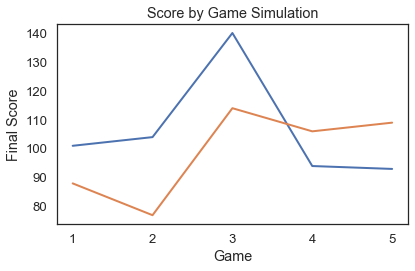

In [66]:
plot(matchup_results.team_one_score)
plot(matchup_results.team_two_score)
decorate(title='Score by Game Simulation',
         xlabel='Game', 
         ylabel='Final Score',
         legend=None)

Following function determines the series winner based on the win totals

In [67]:
def determine_series_winner(team_one, team_two, results):
    """
    Determine the series winner based on the results object from a matchup
    """
    
    winner = team_two
    
    if (results.team_one_wins > results.team_two_wins):
        winner = team_one
        
    return winner

Utility function to output the results of a series outcome to show progress in the simulate_playoffs function along with the results of each series.

In [68]:
def output_playoff_series_result(team_one, team_two, results):
    """
    Display to screen the playoff series result
    """
    
    print("===== Series Result =====")
    
    print(team_one, "wins:", results.team_one_wins)
    print(team_two, "wins:", results.team_two_wins)
    
    if (results.team_one_wins > results.team_two_wins):
        print ("Series Winner:", team_one)
    else:
        print ("Series Winner:", team_two)

simulate_playoffs function runs a tournament simulation for sixteen teams.

In [69]:
def simulate_playoffs(eastern_conf, western_conf, games_per_series_sim):
    """
    Simulate NBA playoffs
    """
    
    # Set number of game simulations per matchup
    games = games_per_series_sim
    
    # ===== Simulate first round =====
    
    # Eastern conference
    first_rd_east_series_one_results, first_rd_east_series_one_pt_diffs = simulate_matchup_between_two_teams(eastern_conf[0], eastern_conf[7], games)
    first_rd_east_series_one_winner = determine_series_winner(eastern_conf[0], eastern_conf[7], first_rd_east_series_one_results)
    output_playoff_series_result(eastern_conf[0], eastern_conf[7], first_rd_east_series_one_results)
    
    first_rd_east_series_two_results, first_rd_east_series_two_pt_diffs = simulate_matchup_between_two_teams(eastern_conf[3], eastern_conf[4], games)
    first_rd_east_series_two_winner = determine_series_winner(eastern_conf[3], eastern_conf[4], first_rd_east_series_two_results)
    output_playoff_series_result(eastern_conf[3], eastern_conf[4], first_rd_east_series_two_results)
    
    first_rd_east_series_three_results, first_rd_east_series_three_pt_diffs = simulate_matchup_between_two_teams(eastern_conf[1], eastern_conf[6], games)
    first_rd_east_series_three_winner = determine_series_winner(eastern_conf[1], eastern_conf[6], first_rd_east_series_three_results)
    output_playoff_series_result(eastern_conf[1], eastern_conf[6], first_rd_east_series_three_results)
    
    first_rd_east_series_four_results, first_rd_east_series_four_pt_diffs = simulate_matchup_between_two_teams(eastern_conf[2], eastern_conf[5], games)
    first_rd_east_series_four_winner = determine_series_winner(eastern_conf[2], eastern_conf[5], first_rd_east_series_four_results)
    output_playoff_series_result(eastern_conf[2], eastern_conf[5], first_rd_east_series_four_results)
    
    
    # Western conference
    first_rd_west_series_one_results, first_rd_west_series_one_pt_diffs = simulate_matchup_between_two_teams(western_conf[0], western_conf[7], games)
    first_rd_west_series_one_winner = determine_series_winner(western_conf[0], western_conf[7], first_rd_west_series_one_results)
    output_playoff_series_result(western_conf[0], western_conf[7], first_rd_west_series_one_results)
    
    first_rd_west_series_two_results, first_rd_west_series_two_pt_diffs = simulate_matchup_between_two_teams(western_conf[3], western_conf[4], games)
    first_rd_west_series_two_winner = determine_series_winner(western_conf[3], western_conf[4], first_rd_west_series_two_results)
    output_playoff_series_result(western_conf[3], western_conf[4], first_rd_west_series_two_results)
    
    first_rd_west_series_three_results, first_rd_west_series_three_pt_diffs = simulate_matchup_between_two_teams(western_conf[1], western_conf[6], games)
    first_rd_west_series_three_winner = determine_series_winner(western_conf[1], western_conf[6], first_rd_west_series_three_results)
    output_playoff_series_result(western_conf[1], western_conf[6], first_rd_west_series_three_results)
    
    first_rd_west_series_four_results, first_rd_west_series_four_pt_diffs = simulate_matchup_between_two_teams(western_conf[2], western_conf[5], games)
    first_rd_west_series_four_winner = determine_series_winner(western_conf[2], western_conf[5], first_rd_west_series_four_results)
    output_playoff_series_result(western_conf[2], western_conf[5], first_rd_west_series_four_results)

        
    # ===== Simulate second round =====
    
    # Eastern Conference
    second_rd_east_series_one_results, second_rd_east_series_one_pt_diffs = simulate_matchup_between_two_teams(first_rd_east_series_one_winner, first_rd_east_series_two_winner, games)
    second_rd_east_series_one_winner = determine_series_winner(first_rd_east_series_one_winner, first_rd_east_series_two_winner, second_rd_east_series_one_results)
    output_playoff_series_result(first_rd_east_series_one_winner, first_rd_east_series_two_winner, second_rd_east_series_one_results)
    
    second_rd_east_series_two_results, second_rd_east_series_two_pt_diffs = simulate_matchup_between_two_teams(first_rd_east_series_three_winner, first_rd_east_series_four_winner, games)
    second_rd_east_series_two_winner = determine_series_winner(first_rd_east_series_three_winner, first_rd_east_series_four_winner, second_rd_east_series_two_results)
    output_playoff_series_result(first_rd_east_series_three_winner, first_rd_east_series_four_winner, second_rd_east_series_two_results)

    # Western Conference
    second_rd_west_series_one_results, second_rd_west_series_one_pt_diffs = simulate_matchup_between_two_teams(first_rd_west_series_one_winner, first_rd_west_series_two_winner, games)
    second_rd_west_series_one_winner = determine_series_winner(first_rd_west_series_one_winner, first_rd_west_series_two_winner, second_rd_west_series_one_results)
    output_playoff_series_result(first_rd_west_series_one_winner, first_rd_west_series_two_winner, second_rd_west_series_one_results)
    
    second_rd_west_series_two_results, second_rd_west_series_two_pt_diffs = simulate_matchup_between_two_teams(first_rd_west_series_three_winner, first_rd_west_series_four_winner, games)
    second_rd_west_series_two_winner = determine_series_winner(first_rd_west_series_three_winner, first_rd_west_series_four_winner, second_rd_west_series_two_results)
    output_playoff_series_result(first_rd_west_series_three_winner, first_rd_west_series_four_winner, second_rd_west_series_two_results)

        
    # ===== Simulate conference finals =====
    
    # Eastern Conference
    third_rd_east_series_one_results, third_rd_east_series_one_pt_diffs = simulate_matchup_between_two_teams(second_rd_east_series_one_winner, second_rd_east_series_two_winner, games)
    third_rd_east_series_one_winner = determine_series_winner(second_rd_east_series_one_winner, second_rd_east_series_two_winner, third_rd_east_series_one_results)
    output_playoff_series_result(second_rd_east_series_one_winner, second_rd_east_series_two_winner, third_rd_east_series_one_results)

    # Western Conference
    third_rd_west_series_one_results, third_rd_west_series_one_pt_diffs = simulate_matchup_between_two_teams(second_rd_west_series_one_winner, second_rd_west_series_two_winner, games)
    third_rd_west_series_one_winner = determine_series_winner(second_rd_west_series_one_winner, second_rd_west_series_two_winner, third_rd_west_series_one_results)
    output_playoff_series_result(second_rd_west_series_one_winner, second_rd_west_series_two_winner, third_rd_west_series_one_results)

    
    # ===== Simulate NBA finals =====
    nba_finals_results, nba_finals_pt_diffs = simulate_matchup_between_two_teams(third_rd_east_series_one_winner, third_rd_west_series_one_winner, games)
    nba_finals_winner = determine_series_winner(third_rd_east_series_one_winner, third_rd_west_series_one_winner, nba_finals_results)
    output_playoff_series_result(third_rd_east_series_one_winner, third_rd_west_series_one_winner, nba_finals_results)

    
    return nba_finals_winner


In [70]:
# Test output_playoff_series_result
output_playoff_series_result('DAL', 'NYK', matchup_results)

===== Series Result =====
DAL wins: 3
NYK wins: 2
Series Winner: DAL


## Playoff simulation

Set the variable 'simulations_per_series' appropriately. 101 should be sufficient. Remember, the higher the number, the longer the playoff simulation will take to complete.

In [71]:
# Standings as of July 11, 2020
east = ['MIL', 'TOR', 'BOS', 'MIA', 'IND', 'PHI', 'BKN', 'ORL']
west = ['LAL', 'LAC', 'DEN', 'UTA', 'OKC', 'HOU', 'DAL', 'MEM']

simulations_per_series = 5

# Test simulate_playoffs
start_time = time.time()

simulate_playoffs(east, west, simulations_per_series)

print("--- %s seconds ---" % (time.time() - start_time))

Matchup run time: 2.6380820274353027 seconds ---
===== Series Result =====
MIL wins: 5
ORL wins: 0
Series Winner: MIL
Matchup run time: 2.956409215927124 seconds ---
===== Series Result =====
MIA wins: 2
IND wins: 3
Series Winner: IND
Matchup run time: 4.2472288608551025 seconds ---
===== Series Result =====
TOR wins: 2
BKN wins: 3
Series Winner: BKN
Matchup run time: 5.983778715133667 seconds ---
===== Series Result =====
BOS wins: 1
PHI wins: 4
Series Winner: PHI
Matchup run time: 6.586961030960083 seconds ---
===== Series Result =====
LAL wins: 4
MEM wins: 1
Series Winner: LAL
Matchup run time: 4.0790956020355225 seconds ---
===== Series Result =====
UTA wins: 3
OKC wins: 2
Series Winner: UTA
Matchup run time: 3.0144941806793213 seconds ---
===== Series Result =====
LAC wins: 4
DAL wins: 1
Series Winner: LAC
Matchup run time: 2.8073618412017822 seconds ---
===== Series Result =====
DEN wins: 5
HOU wins: 0
Series Winner: DEN
Matchup run time: 3.057384967803955 seconds ---
===== Serie